In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from scipy import stats

In [2]:
# If Surface fluxes are available
SF = True
tree_depth = 4

In [3]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
dt_OG = xr.open_mfdataset('BSP_processed/dtime*.nc')
dt_OG = dt_OG.sel(time=slice('1979-01-16', '2014-12-16'))
dt = dt_OG.copy(deep=True)
dt['time'] = np.arange(dt.average_DT.size).astype(float)
dt = dt.rename({'time':'Time'})
rho = 1035 #kg/m^3
Cp = 4000
S0=35

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
range_yrs = init_late-init_early+1

weighted_months = np.array([31,28.25,31,30,31,30,31,31,30,31,30,31])


In [4]:
%%time
ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_4*.nc')

## Early Period
Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ERA5_BSP_data.Basin.values

CPU times: user 489 ms, sys: 45.9 ms, total: 535 ms
Wall time: 713 ms


In [5]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [6]:
## Load SF data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = (((ERA5_BSP_data.hfds_sum*dt.average_DT)).cumsum('Time').isel(Time=-1))\
        -(((ERA5_BSP_data.hfds_sum*dt.average_DT)).cumsum('Time').isel(Time=Early_period[0])) # units: J
    WFO_cumsum = ((ERA5_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=-1)\
         -(((ERA5_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

    ## Get it in W/m2 and mm/day
    dhfds_flux = dhfds/(range_yrs*yr2sec*A_late)
    dwfo_flux = dwfo/(range_yrs*yr2sec*A_late*rho)*1000*24*3600
    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_late) # units: C
    dS_wfo = -dwfo*S0/(rho*V_late) # units: g/kg

    time = ERA5_BSP_data.Time.values
    
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [7]:
EN4_dArea = xr.open_mfdataset('~/UNSW_Work/EN4_Data/EN_Data/EN4_CT_SA_000.nc')
EN4_dArea = EN4_dArea.dArea.load()

In [8]:
if SF:
    data_ERA5 = xr.open_mfdataset('~/UNSW_Work/ERA5/*') ## hfds: W; wfo: kgs^-1

    dt_OG['time'] = data_ERA5.time

    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum_ERA5 = (data_ERA5.hfds*dt_OG.average_DT).cumsum('time').isel(time=-1)/EN4_dArea # units: J/m2
    WFO_cumsum_ERA5 = (data_ERA5.wfo*dt_OG.average_DT).cumsum('time').isel(time=-1)/EN4_dArea # units: kg/m2

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    hfds_ERA5 = HFDS_cumsum_ERA5*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))*(1/(range_yrs*yr2sec)) # units: W/m2
    dwfo_ERA5 = WFO_cumsum_ERA5*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))*(1/(range_yrs*yr2sec)) # units: kg/s/m2
    wfo_ERA5 = dwfo_ERA5/(rho)*24*3600*1000 # UNITS: mm/day

    hfds_ERA5.load()
    wfo_ERA5.load()

In [9]:
if SF:
    expt_ID = 'EN4_known_Qprior'
    file_path = 'Optimisation_results/'+expt_ID+'_transports.nc'

    Opt_result = xr.open_mfdataset(file_path)
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
else:
    expt_ID = 'EN4_no_Qprior'
    file_path = 'Optimisation_results/'+expt_ID+'_transports.nc'

    Opt_result = xr.open_mfdataset(file_path)
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')

mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [10]:
EN4_mapped_masks = xr.open_mfdataset('Masks_processed/EN4_mask_%i_bins.nc' %(tree_depth))
fuzz_combined = (EN4_mapped_masks.Abs_Sal.isel(time=slice(Early_period[0],Early_period[1])).sum('time')/(dyrs*12)).values

mask_EN4_xr = xr.open_mfdataset('Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)

lons = mask_EN4_xr.lon
lats = mask_EN4_xr.lat

## Load SF data here, if provided
if SF:
    dhfds_flux_vals = dhfds_flux.values
    dwfo_flux_vals = dwfo_flux.values

dS_adj = Opt_result.dS_adjustment.values.reshape(Basins.size,SA_late.shape[-1])
dT_adj = Opt_result.dT_adjustment.values.reshape(Basins.size,SA_late.shape[-1])

dwfo_adj = -dS_adj*(rho*V_late.values)/S0 # units: kg # swapped from V_early
dhfds_adj = dT_adj*(Cp*rho*V_late.values) # units: J # swapped from V_early

## Get it in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_late.values) # swapped from V_early
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_late.values*rho)*1000*24*3600 # swapped from V_early

In [11]:
if SF:
        hfds_tot = 0
        wfo_tot = 0
        for i in (range(SA_early.shape[-1])):
                tmp_dhfds = 0
                tmp_dwfo = 0
                for j in range(Basins.size):
                        tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dhfds = tmp+tmp_dhfds
                        tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dwfo = tmp+tmp_dwfo
                hfds_tot = tmp_dhfds+hfds_tot
                wfo_tot = tmp_dwfo+wfo_tot

dS_adj_tot = 0
dT_adj_tot = 0
for i in (range(SA_early.shape[-1])):
    tmp_dS_adj = 0
    tmp_dT_adj = 0
    for j in range(Basins.size):
            tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dS_adj = tmp+tmp_dS_adj
            tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dT_adj = tmp+tmp_dT_adj
    dS_adj_tot = tmp_dS_adj+dS_adj_tot
    dT_adj_tot = tmp_dT_adj+dT_adj_tot

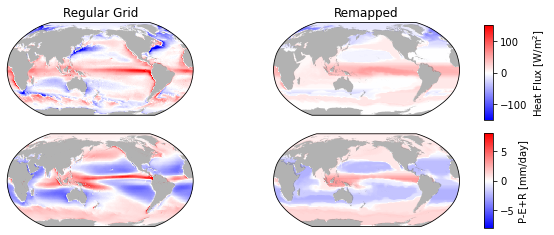

In [12]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    hfds_ERA5.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax2.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -8,8
    wfo_ERA5.plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax4.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax1.set_title('Regular Grid')
    ax2.set_title('Remapped')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('Figures/net_hfds_wfo_ERA5.png', bbox_inches='tight', dpi=300)

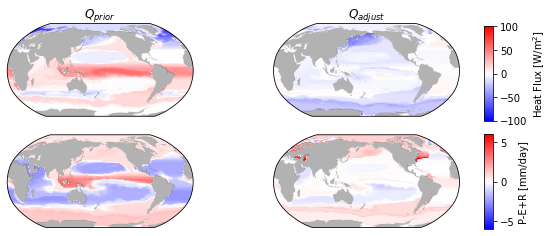

In [15]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -100,100

    ax1.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


    ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -6,6

    ax3.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax4.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax1.set_title('$Q_{prior}$')
    ax2.set_title('$Q_{adjust}$')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('Figures/hfds_wfo_adj_vs_actual.png', bbox_inches='tight', dpi=300)

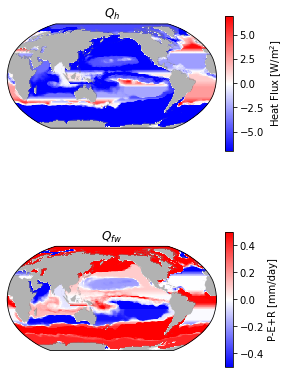

In [14]:
fig  = plt.figure(1, figsize = (7.5*0.5, 7.5))
gs = gridspec.GridSpec(2,1)
gs.update(wspace = 0.1, hspace=0.2)

ax1, ax2 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180))
minv, maxv = -7,7

ax1.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.93,0.57, 0.03, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

minv, maxv = -.5,.5

ax2.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

ax1.set_title('$Q_{h}$')
ax2.set_title('$Q_{fw}$')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.93, 0.17, 0.03, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')
plt.savefig('Figures/hfds_wfo_adj_freerun.png', bbox_inches='tight', dpi=300)